In [51]:
import os
import json
import numpy as np

In [52]:
import pandas as pd
import re

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [54]:
save_dir = os.getcwd() + '/keras-apache-mxnet/benchmark/scripts/experiments/'

In [55]:
os.listdir(save_dir + '/gpu_config')

['tensorflow_1.8.0', 'mxnet_1.2.0']

In [56]:
def get_benchmark(save_dir='expreiments/', backend_nm='tensorflow', model_type='lstm', config='cpu_config', ver='1_2_0'):
    
    wrk_dir=save_dir + config + '/' + backend_nm + '_' +  ver + '/'
    files_tmp=os.listdir(wrk_dir)
    
    files=[i for i in files_tmp if re.findall(".+{model_type}.+".format(model_type=model_type), i)]

    train_times = []
    infer_times = []
    
    for filename in files: 
        with open(str(wrk_dir + filename), 'r') as f:
            lines=f.readlines()
            train_time=0
            for idx, line in enumerate(lines):
                
                if idx == 0:
                    continue
                
                train_time_tmp = re.findall('time: ([0-9]+\.[0-9]+) msec', line)
                
                if len(train_time_tmp) == 1:
                    train_time += float(train_time_tmp[0]) / 1000
                else:
                    train_time += float(re.findall('time: ([0-9]+\.[0-9]+) sec', line)[0])
                
            train_times.append(train_time)
  
    return train_times, infer_times

In [57]:
def summary_benchmark(save_dir, config='cpu_config', backend_nm='tensorflow', version={'mxnet':['1_2_0', '1_1_0'], 'tensorflow':['1_4_1']}):
    tot_res = pd.DataFrame()

    for i in ['resnet50', 'mnist_mlp', 'lstm']:
        for j in set(version.keys()):
            for k in version[j]:
                res = get_benchmark(save_dir=save_dir, backend_nm=j, model_type=i, config=config, ver=k)
                tmp = pd.DataFrame([res[0], res[1]]).transpose().rename(columns={0:'train', 1:'infer'})
                tmp['model_type'] = pd.Series(np.repeat(i,len(tmp)))
                tmp['backend_nm'] = pd.Series(np.repeat(j + '_' + k,len(tmp)))

                tot_res = pd.concat([tot_res, tmp], axis=0)
                    
    return tot_res

In [58]:
def draw_benchmark(tot_res):
    _, axes = plt.subplots(1*4, 2, sharey=False, figsize=(15,20)) 
    for  idx, i in enumerate(set(tot_res.model_type)):

        df = tot_res[tot_res.model_type == i.replace('\\.', '')]

        sns.stripplot(x="backend_nm", y="train", data=df, linewidth=1,edgecolor='gray', ax = axes[idx,0])
        ax_0 = sns.boxplot(x='backend_nm', y='train', data=df, ax=axes[idx, 0])
        ax_0.set(xlabel='', ylabel='', title = i + '_' + 'train', xmargin=0.05, ymargin=0.15)
        ax_0.set_xticklabels(ax_0.get_xticklabels(),rotation=10)
        ax_0.set_ylabel('time (sec)')
        
        sns.stripplot(x="backend_nm", y="infer", data=df, linewidth=1,edgecolor='gray', ax = axes[idx,1])
        ax_1 = sns.boxplot(x='backend_nm', y='infer', data=df, ax=axes[idx, 1])
        ax_1.set(xlabel='', ylabel='', title = i + '_' + 'infer', xmargin=0.05, ymargin=0.15)
        ax_1.set_xticklabels(ax_1.get_xticklabels(),rotation=10)
        ax_1.set_ylabel('time (sec)')
        

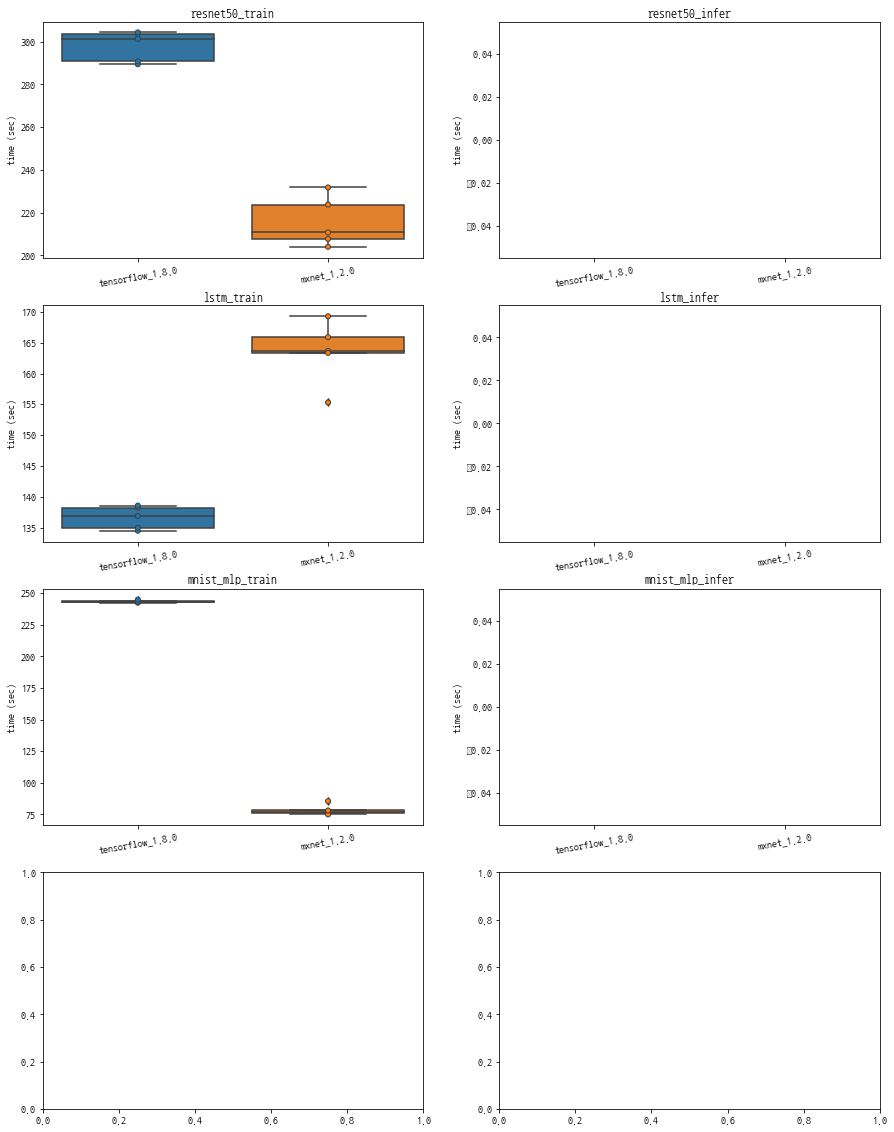

In [59]:
tot_res_cpu = summary_benchmark(save_dir=save_dir, config='cpu_config', version={'mxnet':['1.2.0'], 'tensorflow':['1.8.0']})
draw_benchmark(tot_res_cpu)

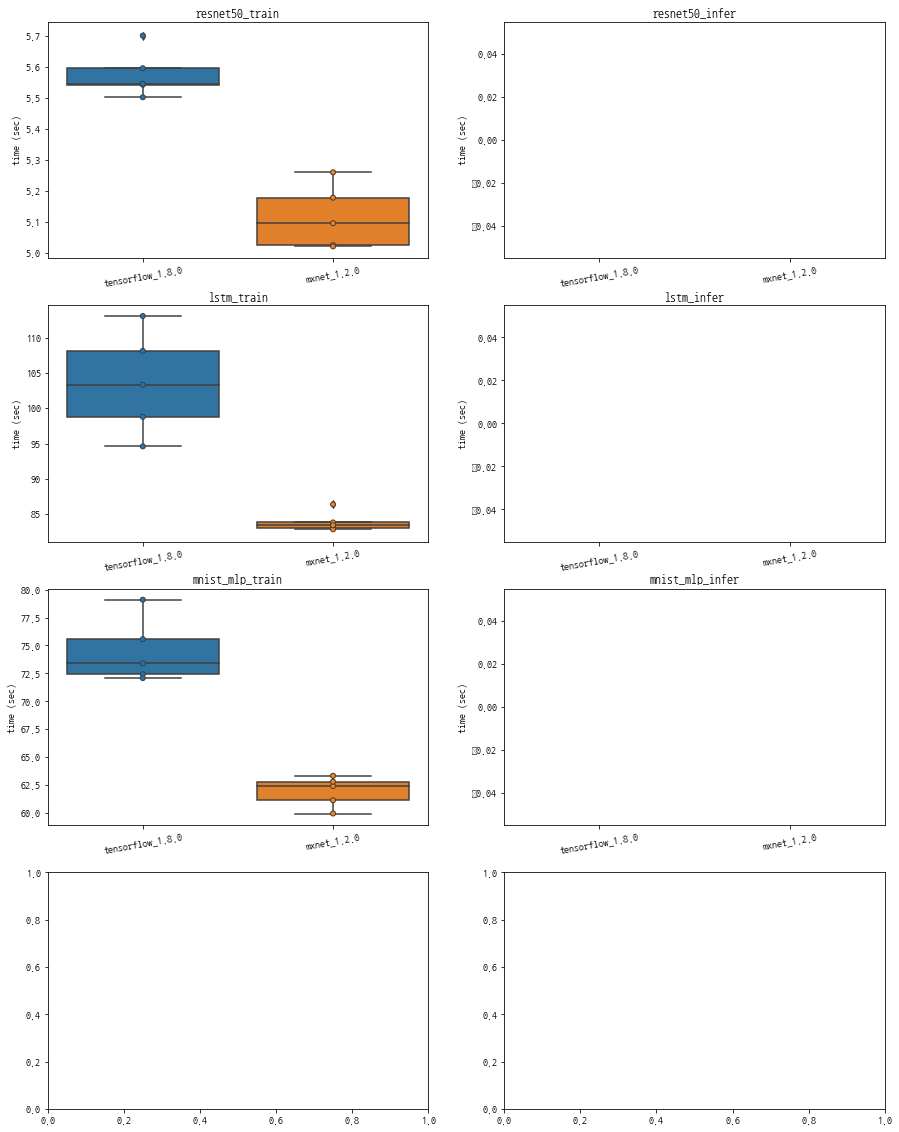

In [60]:
tot_res_gpu = summary_benchmark(save_dir=save_dir, config='gpu_config', version={'mxnet':['1.2.0'], 'tensorflow':['1.8.0']})
draw_benchmark(tot_res_gpu)

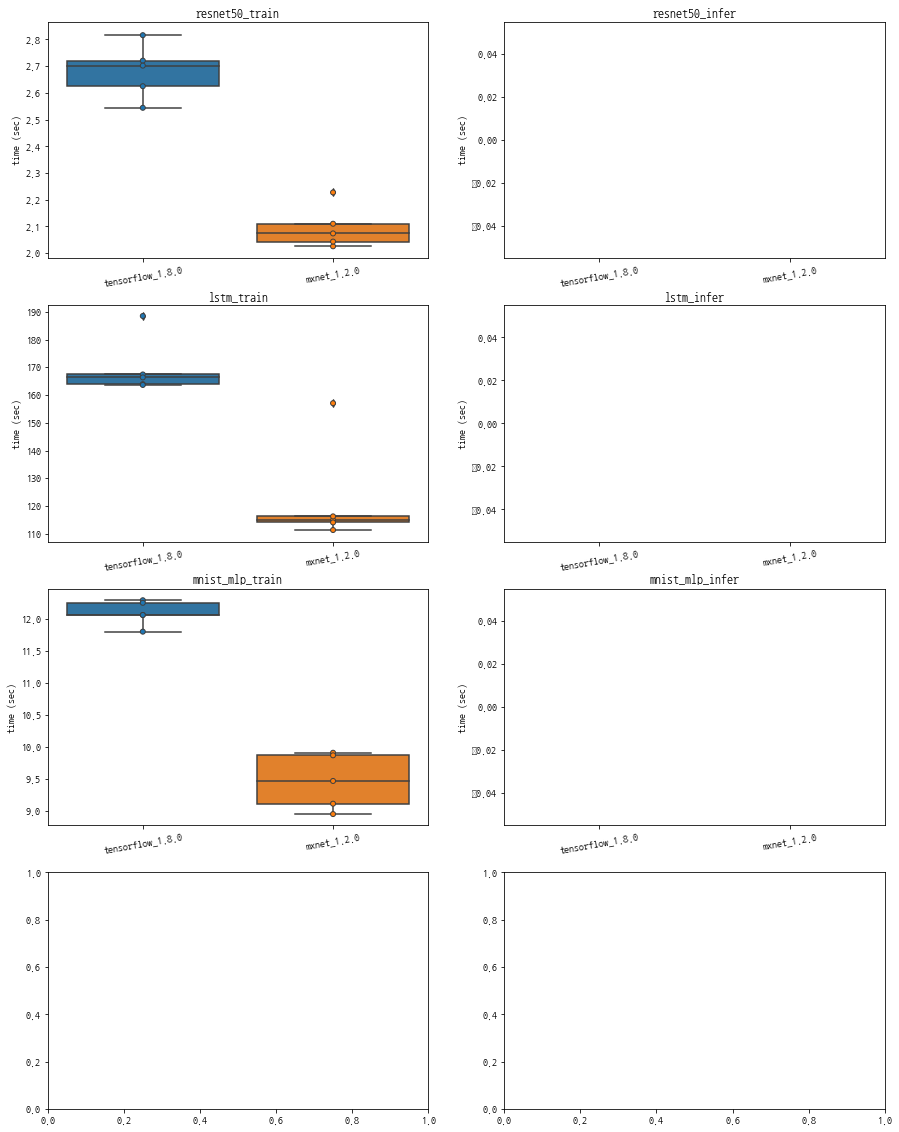

In [61]:
tot_res_gpu_4 = summary_benchmark(save_dir=save_dir, config='4_gpu_config', version={'mxnet':['1.2.0'], 'tensorflow':['1.8.0']})
draw_benchmark(tot_res_gpu_4)

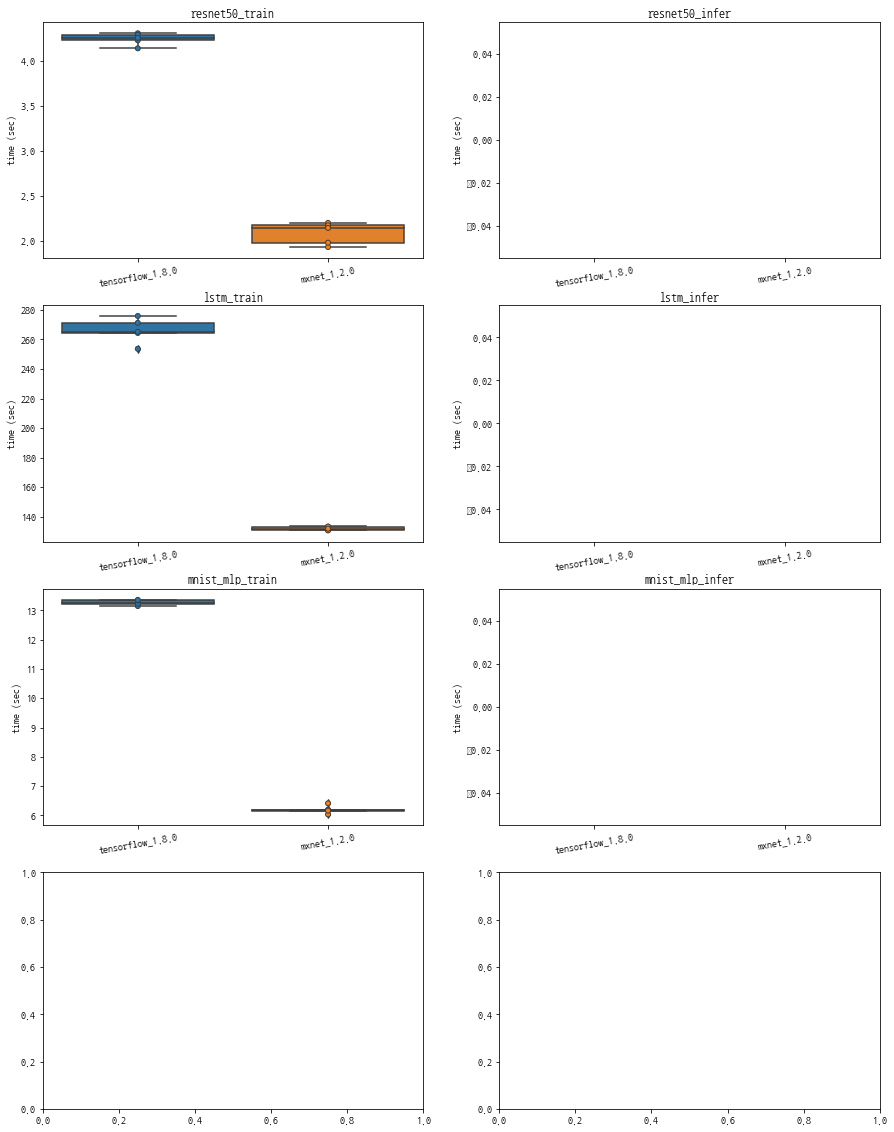

In [305]:
tot_res_gpu_8 = summary_benchmark(save_dir=save_dir, config='8_gpu_config', version={'mxnet':['1.2.0'], 'tensorflow':['1.8.0']})
draw_benchmark(tot_res_gpu_8)

In [329]:
def draw_benchmark_(tot_res, save_file_nm='test.png'):
    
    model_nm = "".join(set(tot_res.model_type))
    
    _, axes = plt.subplots(1, 3, sharey=False, figsize=(6*3,5)) 
        
    for  idx, i in enumerate(set(tot_res.system)):
       
        df = tot_res[tot_res.system == i.replace('\\.', '')]
        
        sns.stripplot(x="backend_nm", y="train", data=df, linewidth=1,edgecolor='gray', ax = axes[idx])
        ax_0 = sns.boxplot(x='backend_nm', y='train', data=df, ax=axes[idx])
        ax_0.set(xlabel='', ylabel='', title = "{}_train_({})".format(model_nm, i),  xmargin=0.05, ymargin=0.15)
        ax_0.set_xticklabels(ax_0.get_xticklabels(),rotation=10)
        ax_0.set_ylabel('time (sec)')

    plt.savefig(save_file_nm, bbox_inches="tight")

In [330]:
## Save between mxnet_1.2.0 vs tensorflow_1.8.0

In [331]:
tot_res_gpu_4['system'] = '4-GPU'

In [332]:
tot_res_gpu['system'] = '1-GPU'

In [333]:
tot_res_cpu['system'] = 'CPU'

In [334]:
tot_res = pd.concat([tot_res_gpu_4, tot_res_gpu, tot_res_cpu])

In [335]:
tot_res.loc[tot_res.model_type == 'mnist_mlp', 'model_type'] = 'mlp'

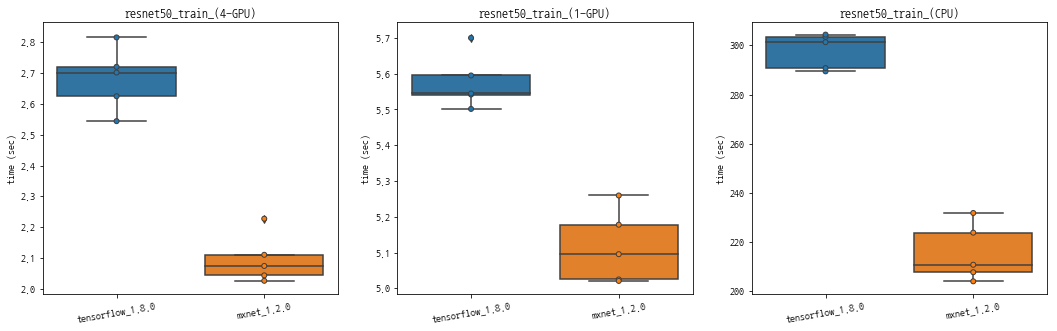

In [336]:
draw_benchmark_(tot_res[tot_res.model_type == 'resnet50'], 'resnet50.png')

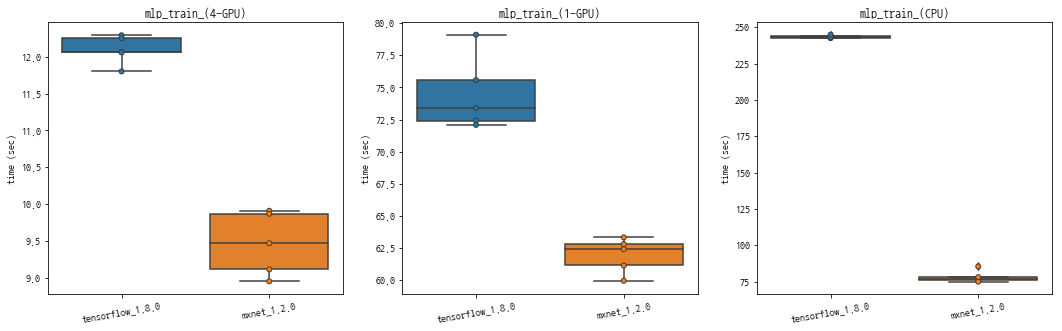

In [337]:
draw_benchmark_(tot_res[tot_res.model_type == 'mlp'], 'mlp.png')

In [316]:
## Comparison between mxnet_1.2.0 vs mxnet_1.1.0

In [319]:
tot_res_gpu = summary_benchmark(save_dir=save_dir, config='gpu_config', version={'mxnet':['1.1.0', '1.2.0']})
draw_benchmark(tot_res_gpu[tot_res_gpu.model_type.isin(['mnist_mlp', 'resnet50'])])

In [ ]:
tot_res_cpu = summary_benchmark(save_dir=save_dir, config='cpu_config', version={'mxnet':['1.1.0', '1.2.0']})
draw_benchmark(tot_res_cpu[tot_res_cpu.model_type.isin(['mnist_mlp', 'resnet50'])])